#Mounting Google Drive in Google Colab


In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

#Accessing Data from kaggle and Extracting Data from a ZIP Archive

In [56]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [57]:
!kaggle datasets download -d jayaprakashpondy/ecgimages

Dataset URL: https://www.kaggle.com/datasets/jayaprakashpondy/ecgimages
License(s): unknown
 99% 284M/286M [00:14<00:00, 24.1MB/s]
100% 286M/286M [00:15<00:00, 20.0MB/s]


In [58]:
import zipfile
zip_ref = zipfile.ZipFile("/content/ecgimages.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

#Importing Important module

In [52]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Edit Image

In [47]:
import os
import cv2

def preprocess_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, filename)
            print(f"Processing: {image_path}")

            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                largest_contour = max(contours, key=cv2.contourArea)

                x, y, w, h = cv2.boundingRect(largest_contour)

                cropped_image = image[y:y+h, x:x+w]

                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, cropped_image)
                print(f"Saved cropped image to: {output_path}")
            else:
                print(f"No contours found in image: {image_path}")

def preprocess_all_categories(archive_folder):
    # Change the output folder to a writable directory in Kaggle
    output_base_folder = '/kaggle/working/cropped_images'

    # Iterate over 'train' and 'test' folders
    for dataset_type in ['train', 'test']:
        dataset_path = os.path.join(archive_folder, dataset_type)
        if os.path.isdir(dataset_path):
            # Iterate over each category folder in 'train' and 'test'
            for category_folder in os.listdir(dataset_path):
                category_path = os.path.join(dataset_path, category_folder)

                if os.path.isdir(category_path):  # Ensure it's a directory
                    output_category_folder = os.path.join(output_base_folder, dataset_type, f"cropped_{category_folder}")
                    preprocess_images_in_folder(category_path, output_category_folder)
                else:
                    print(f"Skipping non-directory item: {category_path}")

# Define your archive folder path
archive_folder = '/kaggle/input/ecgimages'

preprocess_all_categories(archive_folder)

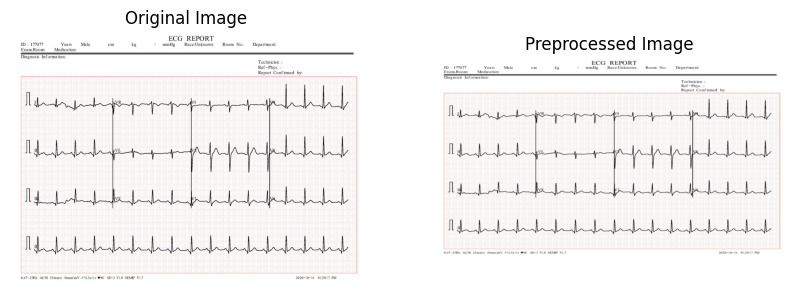

In [59]:

train_path = '/content/train'
test_path = '/content/test'
target_width = 960
target_height = 540

# Function to preprocess image: resizing and blurring
def preprocess_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    resized_image = cv2.resize(blurred_image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

def preview_image(image_path, new_width, new_height):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    resized_image = preprocess_image(image_path, new_width, new_height)

    if resized_image is None:
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Preprocessed Image')
    plt.imshow(resized_image_rgb)
    plt.axis('off')
    plt.show()

# Preview an example image

image_path = '/content/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(100).jpg'  # Replace with an actual image path

preview_image(image_path, target_width, target_height)

#Image augmentation and data loading

In [60]:
# Image data generators for preprocessing images for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators for training, validation, and test datasets
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(target_height, target_width),
    batch_size=16,
    class_mode='categorical'
)

Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.
Found 448 images belonging to 4 classes.


# Building the CNN model

In [61]:
model = Sequential([
    Input(shape=(target_height, target_width, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])


In [62]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 538, 958, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 269, 479, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 267, 477, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 133, 238, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 131, 236, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 65, 118, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 981760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │     125,665,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,759,172 (479.73 MB)

 Trainable params: 125,759,172 (479.73 MB)

 Non-trainable params: 0 (0.00 B)

#Save model and stop early

In [64]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_mobilenet_model.keras', monitor='val_accuracy', save_best_only=True)

#Train model with validation monitoring

In [65]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.2636 - loss: 20.6428 - val_accuracy: 0.4153 - val_loss: 1.3689
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3665 - loss: 2.0486 - val_accuracy: 0.5464 - val_loss: 1.0650
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6371 - loss: 1.4184 - val_accuracy: 0.8525 - val_loss: 0.4406
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 710ms/step - accuracy: 0.8931 - loss: 0.3228 - val_accuracy: 0.8470 - val_loss: 0.3743
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9520 - loss: 0.2074 - val_accuracy: 0.9563 - val_loss: 0.1402
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 715ms/step - accuracy: 0.9818 - loss: 0.0658 - val_accuracy: 0.9290 - val_loss: 0.2249
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 714ms/step - accuracy: 0.9999 - loss: 0.0035 - val_accuracy: 0.8689 - val_loss: 0.4293
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 693ms/step - accuracy: 0.9838 - loss: 0.0481 - val_accuracy: 0.939

#Save final model

In [ ]:
model.save('mymobilenet_final_model.keras')


#Evaluate model on test data

In [66]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 575ms/step - accuracy: 0.9925 - loss: 0.0458
Test Loss: 0.046180643141269684
Test Accuracy: 0.9933035969734192


#Visualizing training and validation performance.


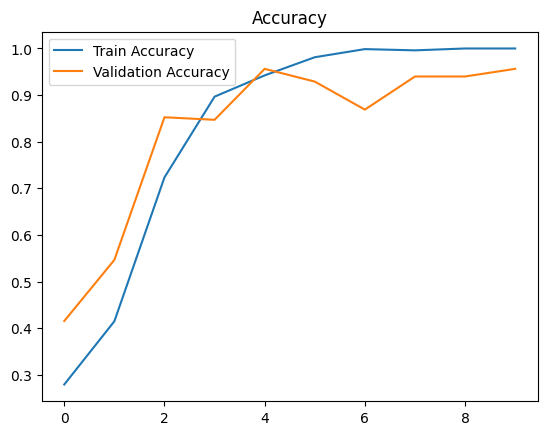

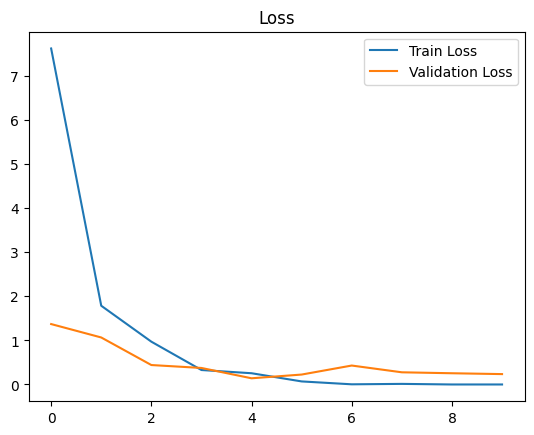

In [67]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()
